In [1]:
import featuretools as ft
from featuretools.primitives import Percentile
import pandas as pd

# Load in data

In [2]:
cyber_df = pd.read_csv("data/CyberFLTenDays.csv").sample(10000)
cyber_df.index.name = "log_id"
cyber_df.reset_index(inplace=True, drop=False)
cyber_df['label'] = cyber_df['label'].map({'N': False, 'A': True}, na_action='ignore')

# Create an EntitySet with many different entities

Each entity is a different definition of "connection"

In [3]:
es = ft.EntitySet("CyberLL")
# create an index column
cyber_df["name_host_pair"] = cyber_df["src_name"].str.cat(
                                [cyber_df["dest_name"],
                                 cyber_df["src_host"],
                                 cyber_df["dest_host"]],
                                sep=' / ')
cyber_df["src_pair"] = cyber_df["src_name"].str.cat(
                                 cyber_df["src_host"],
                                 sep=' / ')
cyber_df["dest_pair"] = cyber_df["dest_name"].str.cat(
                                 cyber_df["dest_host"],
                                 sep=' / ')
es.entity_from_dataframe("log",
                         cyber_df,
                         index="log_id",
                         time_index="secs")
es.normalize_entity(base_entity_id="log",
                    new_entity_id="name_host_pairs",
                    index="name_host_pair",
                    additional_variables=["src_name", "dest_name",
                                          "src_host", "dest_host",
                                          "src_pair",
                                          "dest_pair",
                                          "label"])
es.normalize_entity(base_entity_id="name_host_pairs",
                    new_entity_id="src_pairs",
                    index="src_pair",
                    additional_variables=["src_name", "src_host"])
es.normalize_entity(base_entity_id="src_pairs",
                    new_entity_id="src_names",
                    index="src_name")
es.normalize_entity(base_entity_id="src_pairs",
                    new_entity_id="src_hosts",
                    index="src_host")
es.normalize_entity(base_entity_id="name_host_pairs",
                    new_entity_id="dest_pairs",
                    index="dest_pair",
                    additional_variables=["dest_name", "dest_host"])
es.normalize_entity(base_entity_id="dest_pairs",
                    new_entity_id="dest_names",
                    index="dest_name")
es.normalize_entity(base_entity_id="dest_pairs",
                    new_entity_id="dest_hosts",
                    index="dest_host")

Entityset: CyberLL
  Entities:
    log [Rows: 10000, Columns: 7]
    name_host_pairs [Rows: 8060, Columns: 5]
    src_pairs [Rows: 7376, Columns: 4]
    src_names [Rows: 5769, Columns: 2]
    src_hosts [Rows: 3502, Columns: 2]
    dest_pairs [Rows: 7425, Columns: 4]
    dest_names [Rows: 5783, Columns: 2]
    dest_hosts [Rows: 921, Columns: 2]
  Relationships:
    log.name_host_pair -> name_host_pairs.name_host_pair
    name_host_pairs.src_pair -> src_pairs.src_pair
    src_pairs.src_name -> src_names.src_name
    src_pairs.src_host -> src_hosts.src_host
    name_host_pairs.dest_pair -> dest_pairs.dest_pair
    dest_pairs.dest_name -> dest_names.dest_name
    dest_pairs.dest_host -> dest_hosts.dest_host

## Visualize EntitySet

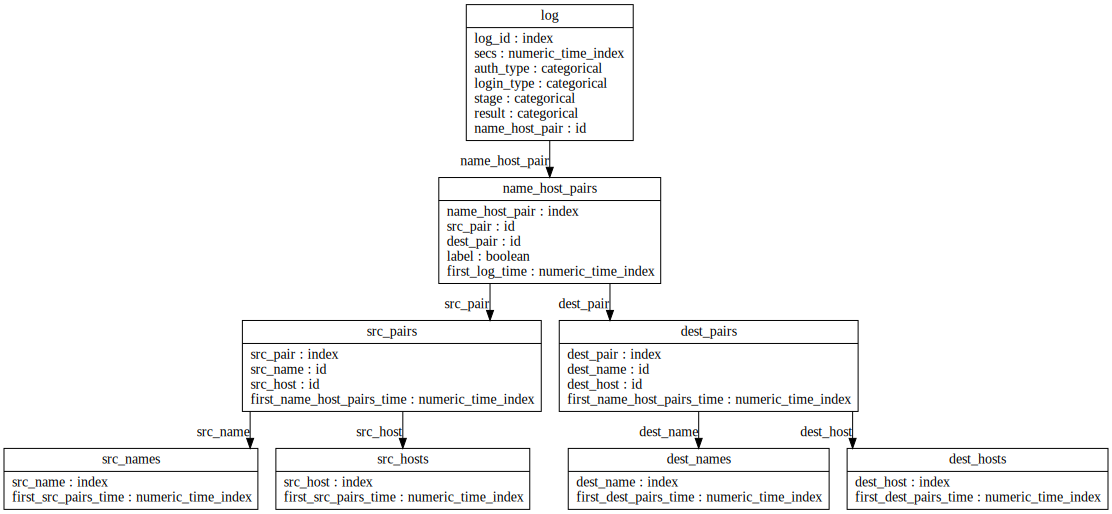

In [4]:
es.plot()

# Define function to generate labels and cutoff times

In [4]:
def generate_cutoffs(cyber_df, index_col, after_n_obs, lead, prediction_window):
    window_start = after_n_obs + lead
    window_end = window_start + prediction_window
    grouped = cyber_df.groupby(index_col)[index_col].count()
    grouped.name = "count"
    min_obs = after_n_obs + lead + 1
    enough_examples = grouped[grouped > min_obs].to_frame().reset_index()
    enough_examples = cyber_df[cyber_df[index_col].isin(enough_examples[index_col])]
    def get_label_and_cutoff(df):
        cutoff = df.iloc[after_n_obs]
        cutoff['label'] = df.iloc[window_start: window_end]["label"].any()
        return cutoff
    cutoffs = enough_examples.groupby(index_col)[[index_col, "secs", "label"]].apply(get_label_and_cutoff)
    return cutoffs

In [5]:
# predict after 3 observations
after_n_obs = 3

# predict 2 observations out
lead = 2

# predict if any malicious attacks in a 10-observation window
window = 10

# Compute features for various types of connections

In [6]:
# features on src_name
cutoffs = generate_cutoffs(cyber_df, "src_name", after_n_obs, lead, window)
fm, fl = ft.dfs(entityset=es, target_entity="src_names", cutoff_time=cutoffs, verbose=True, max_depth=3)

Built 807 features
Elapsed: 03:48 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 10/10 chunks


In [7]:
## features on src_host
cutoffs = generate_cutoffs(cyber_df, "src_host", after_n_obs, lead, window)
fm, fl = ft.dfs(entityset=es, target_entity="src_hosts", cutoff_time=cutoffs, verbose=True, max_depth=3)

Built 807 features
Elapsed: 03:13 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 10/10 chunks


In [8]:
## features on dest_name
cutoffs = generate_cutoffs(cyber_df, "dest_name", after_n_obs, lead, window)
fm, fl = ft.dfs(entityset=es, target_entity="dest_names", cutoff_time=cutoffs, verbose=True, max_depth=3)

Built 807 features
Elapsed: 03:25 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 10/10 chunks


In [9]:
## features on dest_host
cutoffs = generate_cutoffs(cyber_df, "dest_host", after_n_obs, lead, window)
fm, fl = ft.dfs(entityset=es, target_entity="dest_hosts", cutoff_time=cutoffs, verbose=True, max_depth=3)

Built 807 features
Elapsed: 02:59 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 8/8 chunks


In [10]:
# features on src_name/dest_name/src_host/dest_host
cutoffs = generate_cutoffs(cyber_df, "name_host_pair", after_n_obs, lead, window)
fm, fl = ft.dfs(entityset=es, target_entity="name_host_pairs", cutoff_time=cutoffs, verbose=True, max_depth=2, trans_primitives=[Percentile])

Built 99 features
Elapsed: 03:21 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 7/7 chunks


In [11]:
# merge entities together to access the index variables created in the process of normalizing
merged = (es['log'].df
                   .merge(es['name_host_pairs'].df)
                   .merge(es['src_pairs'].df)
                   .merge(es['dest_pairs'].df))

In [12]:
# features on src_name/src_host
cutoffs = generate_cutoffs(merged, 'src_pair', after_n_obs, lead, window)
fm, fl = ft.dfs(entityset=es, target_entity="src_pairs", cutoff_time=cutoffs, verbose=True, max_depth=2, trans_primitives=[Percentile])

Built 205 features
Elapsed: 02:42 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 5/5 chunks


In [13]:
# features on dest_name/dest_host
cutoffs = generate_cutoffs(merged, 'dest_pair', after_n_obs, lead, window)
fm, fl = ft.dfs(entityset=es, target_entity="dest_pairs", cutoff_time=cutoffs, verbose=True, max_depth=2, trans_primitives=[Percentile])

Built 205 features
Elapsed: 03:22 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 5/5 chunks


<p>
    <img src="https://www.featurelabs.com/wp-content/uploads/2017/12/logo.png" alt="Featuretools" />
</p>

Featuretools was created by the developers at [Feature Labs](https://www.featurelabs.com/). If building impactful data science pipelines is important to you or your business, please [get in touch](https://www.featurelabs.com/contact/).